You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os
orig_data_dir = os.getcwd()+'/images'
train_dir = os.getcwd()+"/TRAIN"
test_dir = os.getcwd()+"/TEST"
txt_file_train = os.getcwd()+'/annotations/trainval.txt'
txt_file_test = os.getcwd()+'/annotations/test.txt'

In [ ]:
if not os.path.isdir(train_dir):
  !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

In [ ]:
if not os.path.isdir(train_dir):
  !tar -xvf images.tar.gz

In [ ]:
if not os.path.isdir(train_dir):
  !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
if not os.path.isdir(train_dir):
  !tar -xvf annotations.tar.gz

In [2]:
#"""
# !rm k -r
if not os.path.isdir('k'):
 !git clone -b development12 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
#"""
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1384, done.
remote: Counting objects: 100% (833/833), done.
remote: Compressing objects: 100% (536/536), done.
remote: Total 1384 (delta 612), reused 511 (delta 296), pack-reused 551
Receiving objects: 100% (1384/1384), 15.00 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (968/968), done.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.4-py3-none-any.whl size=57143 sha256=0e66a96f3b4e08a908814f7db420ef88b466d2d6166ac49f3256f0f9ae59b237
  Stored in directory: /tmp/pip-ephem-wheel-cache-0t5kvrf2/wheels/c1/8a/57/56dbba25eff58e52e536543

In [3]:
import cai.layers
import cai.datasets
import cai.models
import cai.mobilenet_v3
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
import PIL
import cv2
#print("Pillow version:", PIL.PILLOW_VERSION)
from sklearn.metrics import classification_report
import shutil

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 2
RAM: 13.622194176 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Fri Nov  5 17:08:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    48W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [5]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [ ]:
def CopyImagesToFolders(orig_data_dir, dest_data_dir, txt_file, verbose=True, prefix='class_'):
  # Load the CSV file.
  # Image CLASS-ID SPECIES BREED ID
  if verbose: print('Loading', txt_file)
  with open (txt_file, "r") as myfile:
    csv_lines=myfile.readlines()

  # Transform the CSV file into an array  
  line_count = 0
  a_lines = []
  for str_line in csv_lines:
    if line_count > 0: 
      a_line = str_line.replace('\n', '').split(' ')
      a_lines.append(a_line)
    line_count = line_count + 1
  
  # create destination folder
  if not os.path.isdir(dest_data_dir):
    os.mkdir(dest_data_dir)

  # Save cropped images
  line_count = 0
  failed_count = 0
  original_count = 0
  last_image_file = ''
  for a_line in a_lines:
    dest_folder_name = dest_data_dir+'/'+prefix+a_line[1]
    dest_file_name = dest_folder_name+'/'+a_line[0]
    orig_file_name = orig_data_dir+'/'+ a_line[0]
    found = False
    if os.path.isfile(orig_file_name+'.jpg'):
      dest_file_name = dest_folder_name+'/'+a_line[0]+'.jpg'
      orig_file_name = orig_data_dir+'/'+ a_line[0]+'.jpg'
      found = True
    if os.path.isfile(orig_file_name+'.png'):
      dest_file_name = dest_folder_name+'/'+a_line[0]+'.png'
      orig_file_name = orig_data_dir+'/'+ a_line[0]+'.png'
      found = True
    if verbose: print(line_count,':', a_line, dest_file_name)
    if (found):
      if not os.path.isdir(dest_folder_name):
        os.mkdir(dest_folder_name)
      if verbose: print('Copying file from', orig_file_name,'to',dest_file_name)
      shutil.copyfile(orig_file_name, dest_file_name)
    else:
      if verbose: print('File does not exist:', orig_file_name)
      failed_count = failed_count + 1
    line_count = line_count + 1
  print("Processed files:", line_count, "Failed count: ", failed_count, "Original count:", original_count)

In [ ]:
if not os.path.isdir(train_dir):
  CopyImagesToFolders(orig_data_dir=orig_data_dir, dest_data_dir=train_dir, txt_file=txt_file_train, verbose=True, prefix='class_')

In [ ]:
if not os.path.isdir(test_dir):
  CopyImagesToFolders(orig_data_dir=orig_data_dir, dest_data_dir=test_dir, txt_file=txt_file_test, verbose=True, prefix='class_')

In [9]:
num_classes = 37
batch_size = 32
epochs = 150
target_size_x = 224 # default value is 224
target_size_y = 224 # default value is 224

In [ ]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['class_28', 'class_4', 'class_33', 'class_16', 'class_14', 'class_20', 'class_29', 'class_22', 'class_18', 'class_24', 'class_7', 'class_12', 'class_5', 'class_32', 'class_25', 'class_35', 'class_36', 'class_13', 'class_23', 'class_37', 'class_15', 'class_27', 'class_2', 'class_30', 'class_3', 'class_21', 'class_9', 'class_34', 'class_26', 'class_11', 'class_6', 'class_19', 'class_8', 'class_17', 'class_10', 'class_31', 'class_1']
['class_28', 'class_4', 'class_33', 'class_16', 'class_14', 'class_20', 'class_29', 'class_22', 'class_18', 'class_24', 'class_7', 'class_12', 'class_5', 'class_32', 'class_25', 'class_35', 'class_36', 'class_13', 'class_23', 'class_37', 'class_15', 'class_27', 'class_2', 'class_30', 'class_3', 'class_21', 'class_9', 'class_34', 'class_26', 'class_11', 'class_6', 'class_19', 'class_8', 'class_17', 'class_10', 'class_31', 'class_1']


In [6]:
datagen = cai.util.create_image_generator(rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, 
  channel_shift_range=0.0) 

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

# Load the dataset

In [ ]:
train_x, val_x, aux_test_x, train_y, val_y, aux_test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=train_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='oxford_pets',
  has_training=True, has_validation=True, has_testing=False,
  training_size=0.9, validation_size=0.1, test_size=0.0,
  smart_resize=True,
  target_size=(target_size_x, target_size_y))

aux_train_x, aux_val_x, test_x, aux_train_y, aux_val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=test_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='oxford_pets',
  has_training=False, has_validation=False, has_testing=True,
  smart_resize=True,
  training_size=0.0, validation_size=0.0, test_size=1,
  target_size=(target_size_x, target_size_y))

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Loading  37  classes.
smart resize is enabled.
loading train images
train shape is: (3309, 224, 224, 3)
loading validation images
validation shape is: (370, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
Loaded.
Loading  37  classes.
smart resize is enabled.
loading test images
test shape is: (3668, 224, 224, 3)
Loaded.
(3309, 224, 224, 3) (370, 224, 224, 3) (3668, 224, 224, 3)
(3309, 37) (370, 37) (3668, 37)


In [7]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [-1, 2, 13]:
      basefilename = 'JP36D02-MobileNetV3Large-OxfordIIIPetDataset-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.mobilenet_v3.MobileNetV3Large(
          input_shape=input_shape,
          alpha=1.0,
          minimalistic=False,
          include_top=True,
          input_tensor=None,
          classes=num_classes,
          pooling=None,
          dropout_rate=0.2)
      else:
        model = cai.mobilenet_v3.kMobileNetV3Large(
          input_shape=input_shape,
          alpha=1.0,
          minimalistic=False,
          include_top=True,
          input_tensor=None,
          classes=num_classes,
          pooling=None,
          dropout_rate=0.2,
          kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary()
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit):
        history = model.fit(
          x = datagen.flow(train_x, train_y, batch_size=batch_size),
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)]
          )
        plt.figure()
        plt.ylabel("Accuracy (training and validation)")
        plt.xlabel("Epochs")
        plt.ylim([0,1])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
      if (test_results):
        print('Best Model Results: '+basefilename)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(test_x,test_y)
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        pred_y = model.predict(test_x)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

# Show Models

In [10]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False)

Running: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['Conv_pad[0][0]']               
                                )                                                                 
                          

# Fitting

Running: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
Epoch 1/150
104/104 [==============================] - 51s 335ms/step - loss: 3.7738 - accuracy: 0.0372 - val_loss: 3.6120 - val_accuracy: 0.0270

Epoch 00001: val_accuracy improved from -inf to 0.02703, saving model to JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/150
104/104 [==============================] - 34s 324ms/step - loss: 3.5988 - accuracy: 0.0348 - val_loss: 3.8944 - val_accuracy: 0.0270

Epoch 00002: val_accuracy did not improve from 0.02703
Epoch 3/150
104/104 [==============================] - 34s 325ms/step - loss: 3.6107 - accuracy: 0.0363 - val_loss: 4.1366 - val_accuracy: 0.0270

Epoch 00003: val_accuracy did not improve from 0.02703
Epoch 4/150
104/104 [==============================] - 34s 325ms/step - loss: 3.6564 - accuracy: 0.0245 - val_loss: 3.8905 - val_accuracy: 0.0270

Epoch 00004: val_accuracy did not improve from 0.02703
Epoch 5/150
104/104 [==============================] - 34s 325ms/step - loss: 3.6573 - accuracy: 0.0254 - val_loss: 3.7726 - val_accuracy: 0.0270

Epoch 00005: val_accuracy did not improve from 0.02703
Epoch 6/150
104/104 [==============================] - 34s 324ms/step - loss: 3.6532 - accuracy: 0.0332 - val_loss: 4.0338 - val_accuracy: 0.0270

Epoch 00006: val_accuracy did not improve fro

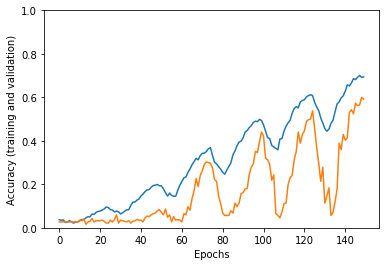

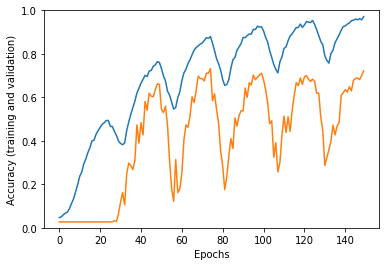

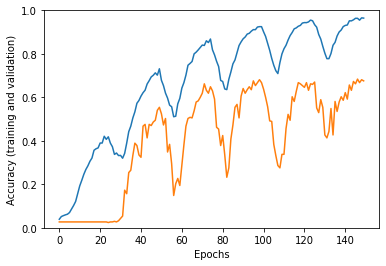

In [ ]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [ ]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True)

Running: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
Best Model Results: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
115/115 [==============================] - 3s 15ms/step - loss: 1.9031 - accuracy: 0.5221
loss 1.9030945301055908
acc 0.5220828652381897
Finished: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
Running: JP36D02-MobileNetV3Large-OxfordIIIPetDataset-2
Best Model Results: JP36D02-MobileNetV3Large-OxfordIIIPetDataset-2
115/115 [==============================] - 11s 35ms/step - loss: 1.7923 - accuracy: 0.6039
loss 1.7922946214675903
acc 0.6038713455200195
Finished: JP36D02-MobileNetV3Large-OxfordIIIPetDataset-2
Running: JP36D02-MobileNetV3Large-OxfordIIIPetDataset-13
Best Model Results: JP36D02-MobileNetV3Large-OxfordIIIPetDataset-13
115/115 [==============================] - 17s 45ms/step - loss: 2.1317 - accuracy: 0.6309
loss 2.13167667388916
acc 0.6308615207672119
Finished: JP36D02-MobileNetV3Large-OxfordIIIPetDataset-13


# Calculate F1

In [ ]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True, calc_f1=True)

Running: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
Best Model Results: JP36D02-MobileNetV3Large-OxfordIIIPetDataset--1
115/115 [==============================] - 3s 15ms/step - loss: 1.9031 - accuracy: 0.5221
loss 1.9030945301055908
acc 0.5220828652381897
Predicted Shape: (3668, 37)
Pred classes shape: (3668,)
Test classes shape: (3668,)
              precision    recall  f1-score   support

           0     0.4651    0.6186    0.5310        97
           1     0.3333    0.3000    0.3158       100
           2     0.4222    0.1900    0.2621       100
           3     0.8333    0.5155    0.6369        97
           4     0.3514    0.2600    0.2989       100
           5     0.5781    0.3700    0.4512       100
           6     0.4952    0.5200    0.5073       100
           7     0.6429    0.6300    0.6364       100
           8     0.7925    0.4200    0.5490       100
           9     0.6607    0.7400    0.6981       100
          10     0.6364    0.5657    0.5989        99
     